In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/4)
overlap = int(SR/8)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        folds=10,
                        random_state=42
                       )

In [6]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000
mean,72.864867,46.555438,39.303472,34.357633,31.580748,31.534475,31.198025,31.341147,30.897054,30.280411,...,0.007040,0.009648,13.515125,24.481013,4.827707,22.530463,5.285919,0.64000,24.500000,5.500
std,20.686417,12.839961,12.632800,10.463501,10.494278,10.720429,10.602236,11.118253,11.124000,10.783517,...,0.158591,0.156010,11.572505,14.782931,5.143978,8.605834,2.296010,0.48012,14.434479,2.873
min,1.023857,1.390291,2.463784,2.217799,1.468053,2.356047,1.082973,0.667087,1.524121,1.350411,...,-0.841209,-1.047266,6.145738,10.621702,2.054451,10.441863,0.843697,0.00000,0.000000,1.000
25%,58.401021,37.259355,29.535553,26.185062,23.092788,22.500621,22.227644,22.170130,22.189913,21.535122,...,-0.073462,-0.069485,10.483121,20.119718,3.742620,17.424135,3.403414,0.00000,12.000000,3.000
50%,72.067949,45.530706,37.705584,33.644909,30.861021,31.213859,31.296936,31.504400,31.393603,31.241432,...,0.009400,0.018312,12.590953,23.350114,4.553567,20.781431,4.865013,1.00000,24.500000,5.500
75%,86.848214,54.964281,47.292583,41.779940,39.835966,39.837809,39.539145,39.920004,39.259747,38.505474,...,0.090130,0.094727,15.309424,26.943112,5.400495,25.663909,6.937377,1.00000,37.000000,8.000
max,210.860506,94.641428,87.565995,74.447375,67.522471,72.120633,83.856240,92.764368,100.907831,98.163545,...,0.708718,0.771758,500.861016,589.306962,221.594445,235.207972,15.894835,1.00000,49.000000,10.000


In [7]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [8]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']

# Training

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
feat_red = PCA(n_components=30)
feat_red.fit(train_X,y=train_y)
train_X = feat_red.transform(train_X)

params = {
          'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
          'gamma': ('auto', 'scale'),
          'decision_function_shape': ('ovo', 'ovr')
         }

svm = SVC(probability=True, max_iter=1000)

clf = GridSearchCV(svm, params, cv=5)

clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decision_function_shape': ('ovo', 'ovr'), 'gamma': ('auto', 'scale'), 'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_decision_function_shape',
 'param_gamma',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [11]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_decision_function_shape,param_gamma,param_kernel,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.181904,0.005446,0.707639,0.720834,ovo,auto,linear,"{'decision_function_shape': 'ovo', 'gamma': 'a...",3,0.702422,...,0.743056,0.700521,0.700348,0.725065,0.696864,0.725065,0.027020,0.000088,0.017878,0.010277
1,0.169222,0.006371,0.644444,0.644445,ovo,auto,poly,"{'decision_function_shape': 'ovo', 'gamma': 'a...",11,0.643599,...,0.645833,0.644097,0.644599,0.644406,0.644599,0.644406,0.001642,0.000032,0.000826,0.000207
2,0.302128,0.010999,0.654861,0.663191,ovo,auto,rbf,"{'decision_function_shape': 'ovo', 'gamma': 'a...",9,0.653979,...,0.652778,0.646701,0.662021,0.673894,0.648084,0.671292,0.003371,0.000025,0.004662,0.009787
3,0.275635,0.010375,0.644444,0.644445,ovo,auto,sigmoid,"{'decision_function_shape': 'ovo', 'gamma': 'a...",11,0.643599,...,0.645833,0.644097,0.644599,0.644406,0.644599,0.644406,0.004044,0.000237,0.000826,0.000207
4,0.174392,0.005753,0.707639,0.720834,ovo,scale,linear,"{'decision_function_shape': 'ovo', 'gamma': 's...",3,0.702422,...,0.743056,0.700521,0.700348,0.725065,0.696864,0.725065,0.004491,0.000331,0.017878,0.010277
5,0.193771,0.006708,0.644444,0.644445,ovo,scale,poly,"{'decision_function_shape': 'ovo', 'gamma': 's...",11,0.643599,...,0.645833,0.644097,0.644599,0.644406,0.644599,0.644406,0.002650,0.000014,0.000826,0.000207
6,0.297840,0.010623,0.715278,0.736110,ovo,scale,rbf,"{'decision_function_shape': 'ovo', 'gamma': 's...",1,0.705882,...,0.753472,0.716146,0.710801,0.738942,0.710801,0.745880,0.006159,0.000178,0.019899,0.010722
7,0.278684,0.010259,0.685417,0.696010,ovo,scale,sigmoid,"{'decision_function_shape': 'ovo', 'gamma': 's...",7,0.692042,...,0.694444,0.676215,0.689895,0.704250,0.672474,0.689506,0.005098,0.000107,0.008541,0.011537
8,0.171358,0.005547,0.707639,0.720834,ovr,auto,linear,"{'decision_function_shape': 'ovr', 'gamma': 'a...",3,0.702422,...,0.743056,0.700521,0.700348,0.725065,0.696864,0.725065,0.003818,0.000135,0.017878,0.010277
9,0.171510,0.006415,0.644444,0.644445,ovr,auto,poly,"{'decision_function_shape': 'ovr', 'gamma': 'a...",11,0.643599,...,0.645833,0.644097,0.644599,0.644406,0.644599,0.644406,0.001881,0.000044,0.000826,0.000207


In [12]:
clf.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=1000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

0.6944444444444444
Confusion matrix, without normalization
[[ 43  96]
 [ 14 207]]


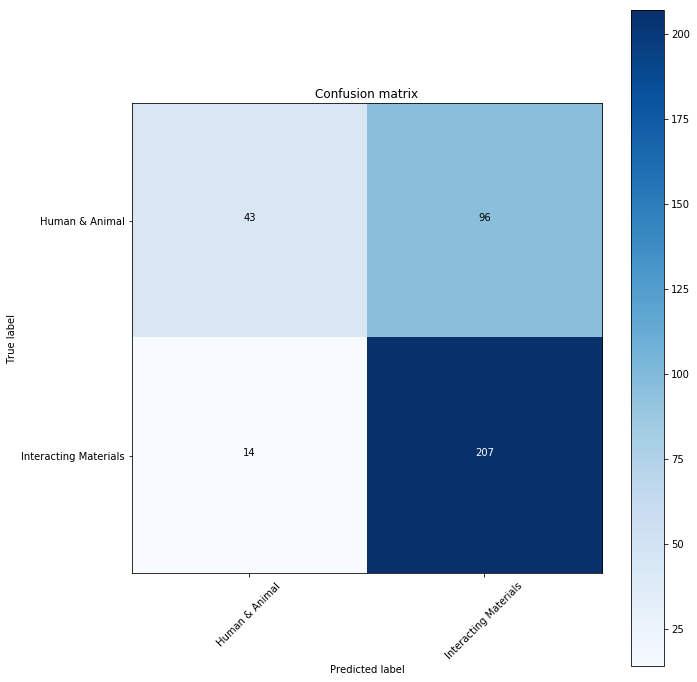

In [13]:
test_X = scaler.transform(test_X)
test_X = feat_red.transform(test_X)
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [14]:
all_df = df[df.fold == 1]

In [15]:
all_df.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
29,92.424748,59.141242,36.846606,20.968241,15.579660,15.751939,15.863563,14.673644,13.023693,10.921275,...,0.080787,-0.115509,18.608194,36.212375,6.859917,33.937771,7.555853,0,8,1
49,80.026334,43.699629,33.855491,26.743481,29.245538,31.119842,25.972480,25.312478,25.158757,22.965982,...,0.006161,0.251638,13.626741,18.341014,4.690726,17.136722,11.156650,0,3,1
56,85.975483,70.241904,68.170603,58.295780,51.781578,50.067378,52.207571,49.074085,45.277827,44.449342,...,0.127927,0.069146,12.966969,18.934236,5.272783,17.825757,6.032061,1,40,1
65,110.385284,61.793937,52.698346,47.364183,46.379313,46.856578,46.282778,46.638665,43.544902,44.590495,...,-0.002064,0.067368,10.146723,17.343412,4.264112,14.344427,4.929389,1,12,1
69,70.094849,35.303785,37.217964,40.640240,32.847498,28.306000,34.013978,37.584400,35.427584,38.294607,...,0.082853,0.128150,12.071106,23.774442,3.617514,20.146890,3.616052,0,4,1


In [16]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['h_target']
X = scaler.transform(X)
X = feat_red.transform(X)

0.71
Confusion matrix, without normalization
[[ 19  50]
 [  8 123]]


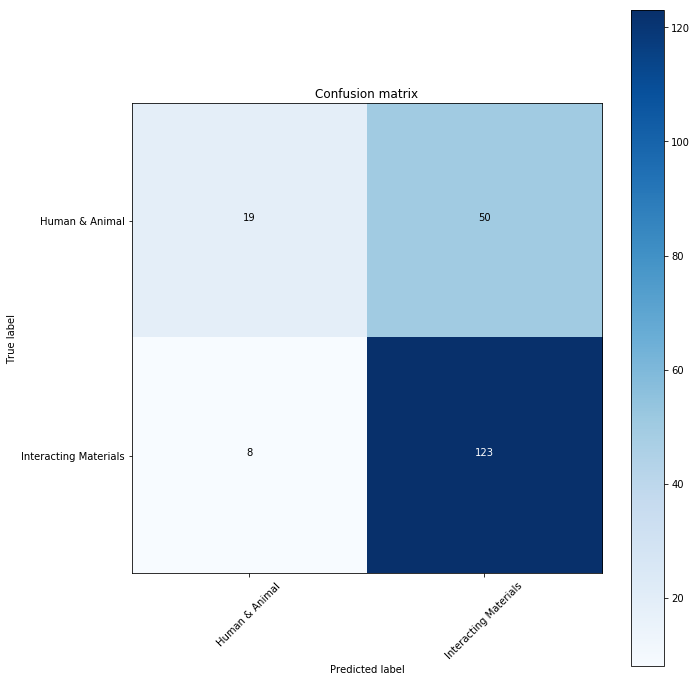

In [17]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [18]:
clf.best_estimator_ 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=1000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
import seaborn as sns
misclassified = {
    'Actual h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}
for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Actual target'].append(classes[int(row[1]['target'])])
        misclassified['Actual h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,Actual h_target,Actual target,Anim_prob,Interact_prob
0,Interacting Materials,sheep,0.375977,0.624023
1,Interacting Materials,frog,0.433924,0.566076
2,Interacting Materials,hen,0.297007,0.702993
3,Interacting Materials,pig,0.327812,0.672188
4,Interacting Materials,pig,0.563610,0.436390


In [20]:
average_prob = misclassified.groupby('Actual h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Actual h_target,,
Human & Animal,0.708190,0.291810
Interacting Materials,0.354183,0.645817


In [21]:
average_prob = misclassified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob
Actual target,,
breathing,0.504880,0.495120
brushing_teeth,0.607224,0.392776
can_opening,0.601589,0.398411
cat,0.173853,0.826147
chirping_birds,0.273385,0.726615
clock_alarm,0.662743,0.337257
coughing,0.349469,0.650531
cow,0.311986,0.688014
crickets,0.246473,0.753527


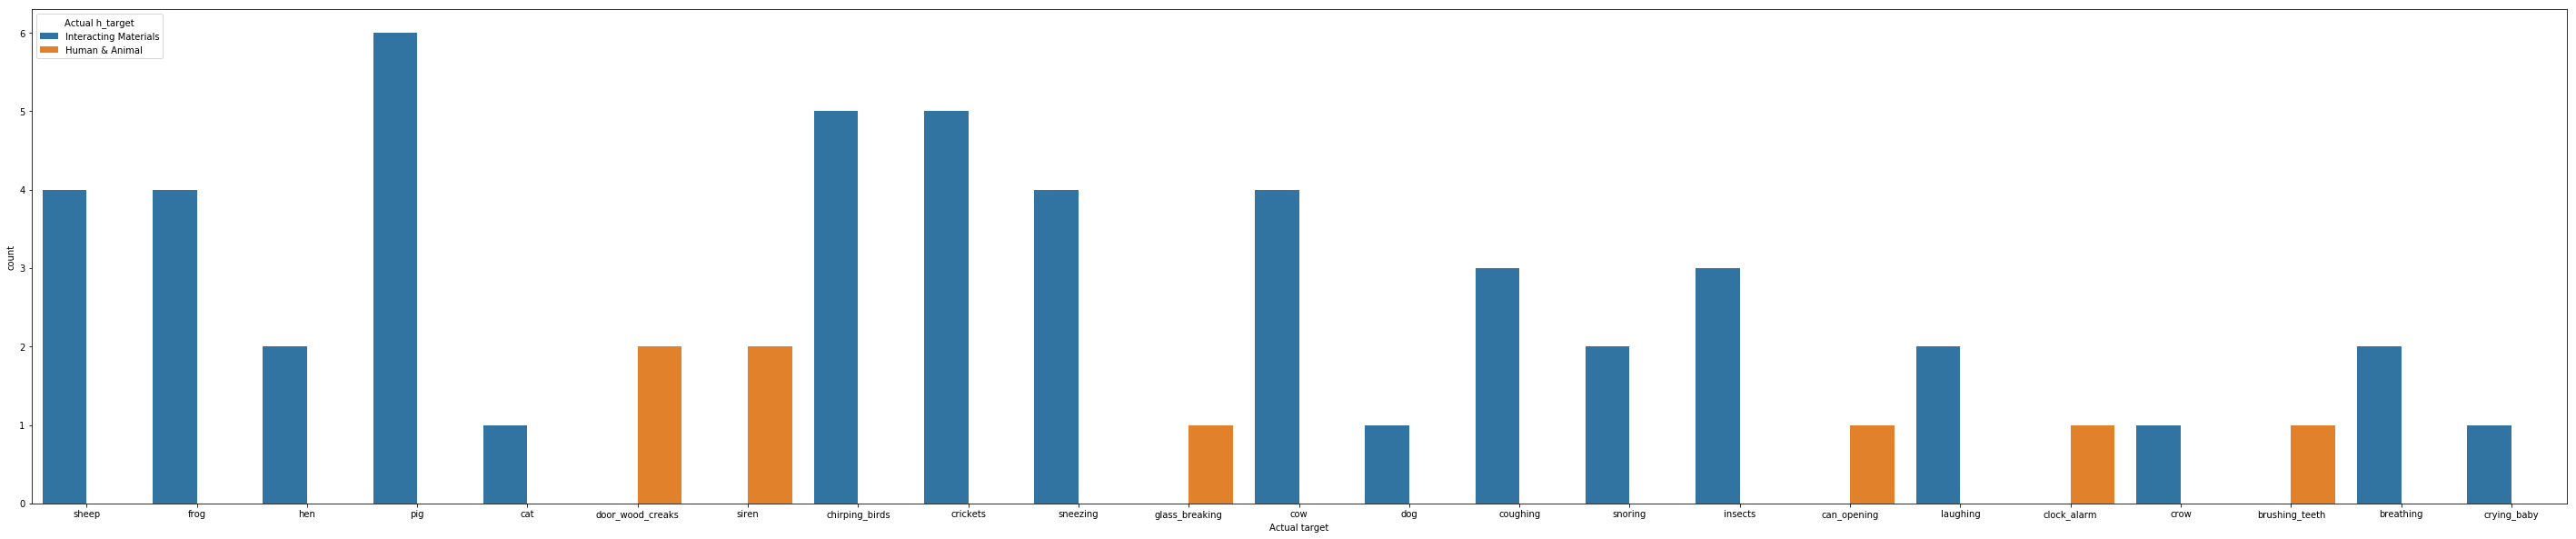

In [22]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='Actual target', hue='Actual h_target',data=misclassified)